In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
courses = ['mmds', 'algorithms', 'compilers', 'stats']
def read_video_data(course):
    return pd.read_csv(
        "./Data/VideoEventsTables/"+course+"_video_events_agg_TABLE.csv"
    )
def read_platform_data(course):
    return pd.read_csv(
        "./Data/PlatformEvents/"+course+"_platform_events_agg_TABLE.csv"
    )
def read_grade_data(course):
    return pd.read_csv(
        "./Data/ActivityGradeTables/" +course+"_activity_grade_agg.csv"
    )

In [3]:
data = {
    course: [read_grade_data(course), 
             read_platform_data(course).drop('Unnamed: 0', axis=1), 
             read_video_data(course).drop('Unnamed: 0', axis=1)]
    for course in courses
}

#### First we build a Base models for each of our courses.
---
* For our base models, we build lasso regression and ridge regression 
models for each of our four courses.
$$
    \sum_{n=1}^{m} \left( \theta^Tx^{(i)} - y^{(i)}\right)^2 + \lVert \theta \rVert^2_2
$$
$$
    \sum_{n=1}^{m} \left( \theta^Tx^{(i)} - y^{(i)}\right)^2 + \lVert \theta \rVert^2_1
$$


In [4]:
'''
We start with Mining Massive Datasets.
'''
def gen_training_data(course):
    cur_course_data = data[course]
    a = cur_course_data[0]
    a.rename(columns={'anon_screen_name':'id'}, inplace=True)
    b = cur_course_data[1]
    b.rename(columns={'total':'total_platform'}, inplace=True)
    c = cur_course_data[2]
    c.rename(columns={'total':'total_video'}, inplace=True)
    return pd.merge(
        pd.merge(a, b, on='id'), c, on='id'
    )

In [5]:
for course in courses:
    print course, gen_training_data(course).shape

mmds (430, 17)
algorithms (333, 17)
compilers (2200, 17)
stats (39616, 17)


In [6]:
def pre_process(data):
    training = data
    maxes = training.max(axis=0)
    max_ = maxes['percent_grade']
    max_v = maxes['total_video']
    max_p = maxes['total_platform']
    max_na = maxes['num_attempts']
    
    cols = [u'courseware', u'discussion',u'download', u'problem', u'save_user_state',
     u'translation', u'total_platform', u'load_video', u'pause_video',
     u'play_video',u'seek_video', u'speed_change_video', u'stop_video', u'total_video']
    training.num_attempts = training.num_attempts / max_na
    training.total_platform = training.total_platform / max_p
    training.total_video = training.total_video / max_v
    for c in cols:
        mean = training[c].mean()
        std =  training[c].std()
        training[c] = training[c].apply(lambda x: (x-mean)/std)
    training['percent_grade'] = training['percent_grade'].apply(lambda x: (x/max_)*100)
    return training

In [7]:
all_data = [pre_process(gen_training_data(course)) for course in courses]
all_data_merged = pd.concat(all_data)

### 1. Baseline Models

In [11]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import learning_curve
def baseline_model(course, model):
    data = gen_training_data(course)
#     training = data[['percent_grade', 'total_video', 'total_platform', 'num_attempts', 'id']]
    training = pre_process(data)
    Y = training['percent_grade'].values
    X = training.drop(['percent_grade','id'], axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
    model.fit(X_train, Y_train)
    y_preds = model.predict(X_test)
    score = mean_squared_error(Y_test, y_preds)
    print np.sqrt(score)

In [96]:
for course in courses: 
    model1 = linear_model.LinearRegression()
    model2 = linear_model.Ridge(0.8)
    print "Current Course is " + course
    baseline_model(course, model1)
    baseline_model(course, model2)

Current Course is mmds
23.6230844479
23.601376817
Current Course is algorithms
19.6200511779
19.5038661633
Current Course is compilers
19.3022770869
19.3344686097
Current Course is stats
12.7870789698
12.7786104242


In [32]:
def evaluate_ridge_regression(training):
    Y = training['percent_grade'].values
    X = training.drop(['percent_grade','id'], axis=1).values
    train_sizes, train_scores, test_scores = learning_curve(
        linear_model.Ridge(), X, Y, train_sizes=[0.2, 0.5, 0.7, 0.8, 0.95],
        scoring=make_scorer(mean_squared_error), cv=6
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, np.sqrt(train_scores_mean),'o-', color='r', label='Training Score')
    plt.plot(train_sizes, np.sqrt(test_scores_mean), 'o-', color='g', label = "Cross Validation Score")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel('Training Data Size')
    plt.title(course+" Ridge Regression Learning Curve")
    plt.savefig(course+'.png')
    plt.show()
    plt.gcf().clear()

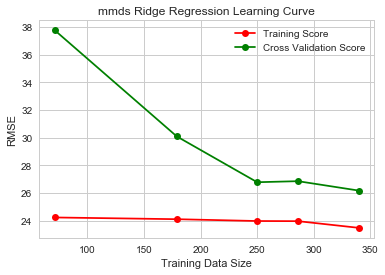

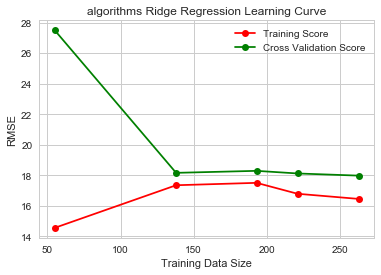

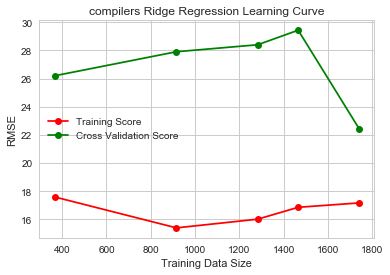

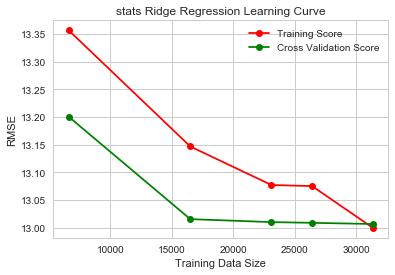

In [33]:
for course in courses: evaluate_ridge_regression(pre_process(gen_training_data(course)))
# evaluate_ridge_regression('stats')

### 2. Model Building Part (II)
* In this section we fit and evaluate the following models:
> * Ridge Regression with all the features. 
> * $L_2$ Regularized Polynomial regression of varying degrees.
> * Neural Network Regression.

* In the next section, we shal turn our task into a classification one.


In [221]:
'''
Ridge Regression With All Features.

Note that we have dropped percent score.
'''
def full_ridge_regression(training, model):
    Y = training['percent_grade'].values
    X = training.drop(['percent_grade','id'], axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
    model.fit(X_train, Y_train)
    y_preds = model.predict(X_test)
    
    score = mean_squared_error(Y_test, y_preds)
    training_score = mean_squared_error(Y_train, model.predict(X_train))
    
    print "Training score = ", np.sqrt(training_score)
    print "Hold out validation score = ", np.sqrt(score)
    
for course in courses: 
    print "course = ", course
    full_ridge_regression(pre_process(gen_training_data(course)), linear_model.Ridge(0.8))
print "All Data"
# all_data_merged.drop(['new_labels'], axis=1, inplace=True)
full_ridge_regression(all_data_merged, linear_model.Ridge(0.8))

course =  mmds
Training score =  23.9463954374
Hold out validation score =  23.601376817
course =  algorithms
Training score =  15.7293345313
Hold out validation score =  19.5038661633
course =  compilers
Training score =  16.7667890415
Hold out validation score =  19.3344686097
course =  stats
Training score =  13.0230830244
Hold out validation score =  12.7786104242
All Data
Training score =  13.4660393931
Hold out validation score =  13.4407796667


* Even with all the features, our RMSE is still high.
* This is b/c we are stil trying to fit a line (more aptly, a hyperplane) to the training data.
* Our features are not linearly related to the output variable.

In [98]:
from sklearn.neighbors import KNeighborsRegressor
def fit_non_linear(training, k, course):
    Y = training['percent_grade'].values
    X = training.drop(['percent_grade','id'], axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
    pmodel = KNeighborsRegressor(n_neighbors=k)
    pmodel.fit(X_train, Y_train)
    y_preds = pmodel.predict(X_test)
    
    score = mean_squared_error(Y_test, y_preds)
    training_score = mean_squared_error(Y_train, pmodel.predict(X_train))
    
    print course, ": RMSE on training data = ", np.sqrt(training_score)
    print course, ": HOCV RMSE = ", np.sqrt(score)

In [222]:
for course in courses:
    fit_non_linear(pre_process(gen_training_data(course)), 10, course)
fit_non_linear(all_data_merged, 10, "all data")

mmds : RMSE on training data =  22.9328783122
mmds : HOCV RMSE =  23.5028490389
algorithms : RMSE on training data =  15.6417952566
algorithms : HOCV RMSE =  20.0234058485
compilers : RMSE on training data =  15.6357554066
compilers : HOCV RMSE =  20.032218983
stats : RMSE on training data =  12.1664050483
stats : HOCV RMSE =  13.2236932489
all data : RMSE on training data =  12.5621827596
all data : HOCV RMSE =  13.7687895658


### 3. Neural Network Regression.

In [12]:
import tensorflow as tf

In [13]:
class MOOCPerformanceNet():
    def layer(self, input, weight_shape, bias_shape, output=False, l=5):
        '''
        Defines a single Affine map layer with a
        non linearity i.e ReLu applied at the end.
        '''
        w_init = tf.contrib.layers.xavier_initializer(uniform=False, seed=None, dtype=tf.float64)
        bias_init = tf.constant_initializer(value=0)

        W = tf.get_variable("W", weight_shape, initializer=w_init)
        b = tf.get_variable("b", bias_shape, initializer=bias_init)
        l2 = tf.nn.l2_loss(W)
        return (tf.matmul(input, W) + b)+(l*l2) if output else tf.nn.relu(tf.matmul(input, W) + b)+(l*l2) 

    def inference(self, x):
        '''
        Defines a single foward pass.
        '''
        with tf.variable_scope("h_1"):
            h_1 = self.layer(x, [15, 225], [225])
            
        with tf.variable_scope("h_2"):
            h_2 = self.layer(h_1, [225, 225], [225])
            
        with tf.variable_scope("h_3"):
            h_3 = self.layer(h_2, [225, 75], [75])
        
        with tf.variable_scope('h_4'):
            h_4 = self.layer(h_3, [75, 25], [25])

        with tf.variable_scope("output"):
            output = self.layer(h_4, [25, 1], [1, 1], output=True)
            
        return output

    def loss(self, output, y):
        loss = tf.losses.mean_squared_error(labels=y, predictions=output)
        return loss

    def training(self, cost, global_step, lr):
        tf.summary.scalar("cost", cost)
        optimizer = tf.train.GradientDescentOptimizer(lr)
        train_op = optimizer.minimize(cost, global_step=global_step)
        return train_op

    def evaluate(self, output, y):
        mse = tf.losses.mean_squared_error(y, output)
        rmse = tf.sqrt(mse)
        tf.summary.scalar("RMSE", rmse)
        return rmse

In [14]:
def nnreg(training, cur):
    Y = training['percent_grade'].values
    X = training.drop(['percent_grade','id'], axis=1).values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
    lr = 0.01
    n_epochs = 100
    costs = []
    with tf.Graph().as_default():
        x = tf.placeholder("float", [None, X_train.shape[1]])
        y = tf.placeholder("float", [None, 1])
        
        nn = MOOCPerformanceNet()

        output = nn.inference(x)
        cost = nn.loss(output, y)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = nn.training(cost, global_step, lr)
        eval_op = nn.evaluate(output, y)
        init_op = tf.global_variables_initializer()

        sess = tf.Session()
        sess.run(init_op)
        Y_train = Y_train.reshape(Y_train.shape[0], 1)
        feed_dict = {x: X_train, y: Y_train}
        for e in xrange(n_epochs):
            sess.run(train_op, feed_dict=feed_dict)
            cur_cost = sess.run(cost, feed_dict=feed_dict)
            cur_cost = np.sqrt(cur_cost)
#             if e % 100 == 0: 
#                 print "Current RMSE = ", cur_cost
#                 costs.append(cur_cost)
                
#         print "Optimization Finished"
    Y_test = Y_test.reshape(Y_test.shape[0], 1)
    test_feed_dict = {x:X_test, y:Y_test}
    test_rmse = sess.run(eval_op, feed_dict=test_feed_dict)
    print "Test RMSE = ", test_rmse
    print "Training course is ", cur
    for course in courses:
        if course == cur: 
            continue
        t = pre_process(gen_training_data(course))
        Y_ts = t['percent_grade'].values
        test_feed_dict = {
            x: t.drop(['percent_grade','id'], axis=1).values,
            y: Y_ts.reshape(Y_ts.shape[0], 1)
        }
        rmse = sess.run(eval_op, feed_dict=test_feed_dict)
        print "\t ", course, " rmse = ", rmse
    return costs

In [15]:
for course in courses:
    nnreg(pre_process(gen_training_data(course)), course)

Test RMSE =  23.4301
Training course is  mmds
	  algorithms  rmse =  17.738
	  compilers  rmse =  17.7408
	  stats  rmse =  14.2846
Test RMSE =  19.5177
Training course is  algorithms
	  mmds  rmse =  24.9125
	  compilers  rmse =  17.3369
	  stats  rmse =  13.014
Test RMSE =  19.319
Training course is  compilers
	  mmds  rmse =  24.6512
	  algorithms  rmse =  16.8866
	  stats  rmse =  13.1215
Test RMSE =  12.8008
Training course is  stats
	  mmds  rmse =  24.9658
	  algorithms  rmse =  16.8281
	  compilers  rmse =  17.361


In [207]:
for course in courses:
    print "Current course is ", course
    nnreg(pre_process(gen_training_data(course)))

Current course is  mmds
Optimization Finished
Test RMSE =  23.4307
Current course is  algorithms
Optimization Finished
Test RMSE =  19.5419
Current course is  compilers
Optimization Finished
Test RMSE =  19.3203
Current course is  stats


KeyboardInterrupt: 

In [229]:
nnreg(all_data_merged)

Current RMSE =  999.357
Optimization Finished
Test RMSE =  13.4579


[]

### 4. Transform Problem To Classification

In [8]:
def discretize(training_data):
    bins = [-0.99, 25, 50, 75, 100]
    grade_bins = ['D', 'C', 'B', 'A']
    training_data['new_labels'] = pd.cut(
        training_data['percent_grade'], 
        bins, labels=grade_bins
    )

In [9]:
discretize(all_data_merged)
all_data_merged.sample(n=10)

,id,num_attempts,percent_grade,courseware,discussion,download,problem,save_user_state,translation,total_platform,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video,total_video,new_labels
36307,ea6aa13ec7684dfcb93463c8b787742109e0d66c,0.114286,0.429185,-0.116797,-0.048916,-0.105359,-0.324338,-0.324307,-0.475448,-0.378172,-0.266013,-0.259983,-0.096850,-0.240071,-0.064353,-0.016621,-0.073611,D
11363,468cdc4bae8efef552f6ee387a0be426815538f0,0.057143,21.888412,-0.237431,-0.048916,-0.105359,-0.324338,-0.324307,0.021794,-0.374369,-0.266013,-0.253893,-0.099152,-0.276311,-0.187544,-0.016941,-0.075903,D
2201,0de4238013721256f6df7727ec8bea747eb24f2d,0.057143,24.034335,-0.237431,-0.041423,-0.105359,-0.324338,-0.319723,-0.456323,-0.418114,-0.266013,-0.266073,-0.100686,-0.276311,-0.064353,-0.016941,-0.076762,D
2043,0cb082c6d6b34a69d85c0ab05cce500c85419c45,0.057143,0.429185,-0.237431,-0.048916,-0.105359,-0.324338,-0.324307,0.289540,-0.347741,-0.266013,-0.266073,-0.096850,-0.276311,-0.187544,-0.016941,-0.075616,D
33680,d922db088e02755dba305112ba62d396e1b70197,0.057143,22.746781,-0.237431,-0.048916,-0.105359,-0.324338,-0.319723,-0.456323,-0.420016,0.322862,-0.028576,-0.050821,-0.031689,0.305218,-0.015982,-0.031788,D
36417,eb06715ef14ff4a3be9d8375f5abb40208f46795,0.057143,1.716738,-0.237431,-0.048916,-0.105359,-0.324338,-0.324307,-0.341575,-0.410506,-0.266013,-0.217356,-0.091480,-0.276311,0.058837,-0.016621,-0.070460,D
8145,327377e9eb7a993745f910923290abb13ee31c61,0.057143,8.583691,-0.237431,-0.048916,-0.105359,-0.324338,-0.131768,-0.150328,-0.311603,-0.266013,-0.266073,-0.086877,-0.167590,-0.187544,-0.016302,-0.067882,D
8341,33e13f2ac76dae9eeadbd2c4bc776b212e6d3b58,0.057143,12.875536,-0.227378,-0.048916,-0.105359,-0.324338,-0.324307,-0.475448,-0.420016,-0.059907,-0.180818,-0.083809,-0.221950,-0.187544,-0.016302,-0.062439,D
10872,434f66599ea35b28222e563ffad8a3df253faafa,0.057143,15.021459,-0.237431,-0.048916,-0.105359,-0.288626,-0.324307,-0.475448,-0.408604,-0.266013,0.409879,0.009784,-0.276311,-0.187544,0.001926,0.012899,D
3839,1889cb28adbe6e38e7965ecebb014226f77e4794,0.133333,0.858369,-0.237431,-0.048916,-0.105359,-0.324338,-0.324307,-0.418074,-0.418114,-0.266013,-0.235624,-0.094549,-0.104169,-0.187544,-0.016621,-0.067595,D


In [10]:
all_data_merged[all_data_merged.percent_grade == 100]

,id,num_attempts,percent_grade,courseware,discussion,download,problem,save_user_state,translation,total_platform,load_video,pause_video,play_video,seek_video,speed_change_video,stop_video,total_video,new_labels
217,88417599004f0fb4b940d865f73695cb72a45e87,0.078125,100.0,-0.174126,-0.201805,-0.064274,-0.141934,-0.201589,-0.311882,-0.256824,-0.213024,-0.284592,-0.215170,-0.239311,-0.171799,-0.122492,-0.282227,A
179,9c846ff8ddfaf3391c4a4808ec3e61908dc278d6,0.055556,100.0,-0.158288,-0.349371,-0.137879,-0.276179,-0.195315,0.000612,-0.249843,-0.249351,-0.317709,-0.321580,0.353524,0.234122,-0.084599,-0.130965,A
293,24b01458f28b154db5ca5b96ad99d366cfa714ef,0.069752,100.0,-0.248762,-0.135775,-0.088366,-0.209012,-0.307642,-0.389314,-0.364740,-0.077175,-0.170872,-0.216948,-0.077419,1.093020,-0.039367,-0.191040,A
294,24b01458f28b154db5ca5b96ad99d366cfa714ef,0.069752,100.0,-0.151345,-0.135775,-0.088366,-0.209012,-0.307642,-0.389314,-0.337385,-0.077175,-0.170872,-0.216948,-0.077419,1.093020,-0.039367,-0.191040,A
32255,cfcdfddad0466d44fbac1bbd3736f74aca1c7d5a,0.057143,100.0,-0.237431,-0.048916,-0.105359,-0.315410,-0.324307,-0.475448,-0.420016,-0.266013,-0.192997,-0.089179,-0.240071,-0.187544,-0.014703,-0.066163,A


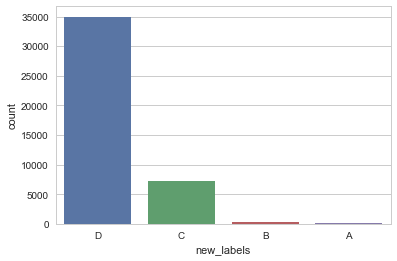

In [11]:
sns.countplot(x='new_labels', data=all_data_merged)
plt.savefig('grade_distr')

In [12]:
x_vis = all_data_merged[[ u'num_attempts', u'courseware', u'discussion',
       u'download', u'problem', u'save_user_state', u'translation',
       u'total_platform', u'load_video', u'pause_video', u'play_video',
       u'seek_video', u'speed_change_video', u'stop_video', u'total_video']]
y_vis = all_data_merged['percent_grade']

## PCA to visualize features.

In [13]:
from sklearn import decomposition
np.random.seed(5)

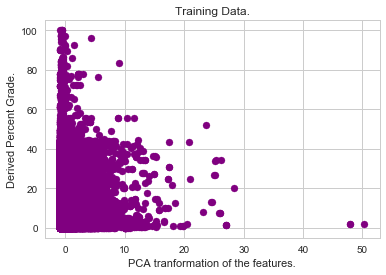

In [14]:
pca = decomposition.PCA(n_components=1)
# x = all_data
pca.fit(x_vis)
x_vis = pca.transform(x_vis)
sns.set_style("whitegrid")
plt.ylabel("Derived Percent Grade.")
plt.xlabel("PCA tranformation of the features.")
plt.title("Training Data.")
plt.scatter(x_vis, y_vis, color='purple')
# sns.lmplot(x=x_vis, y=y_vis)
plt.savefig('data_vis.png')

In [15]:
def categorize(vector):
    Y = []
    for v in vector:
        if v == 'A': 
            Y.append(0)
        elif v == 'B':
            Y.append(1)
        elif v == 'C':
            Y.append(2)
        else:
            Y.append(3)
    return Y

## Softmax Regression

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score
'''
From sklearn's website
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
def multinomial_logistic_reg(course):
    training = pre_process(gen_training_data(course))
    discretize(training)
    Y = np.array(categorize(training['new_labels']))
    X = training.drop(['percent_grade','id', 'new_labels'], axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=13)
    L = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', solver='newton-cg')
    L.fit(X_train, Y_train)
    train_score = L.score(X_train, Y_train)
    s = L.score(X_test, Y_test)
    Y_pred = L.predict(X_test)
    print "Training Accuracy = ", train_score
    print "Testing Accuracy = ", s
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure()
    confusion = confusion_matrix(Y_test, Y_pred)
    plot_confusion_matrix(confusion, ["A", "B", "C", "D"])
    plt.savefig('cnf_log.png')
    
    return f1_score(Y_test, Y_pred, average='weighted')

Training Accuracy =  0.821845395421
Testing Accuracy =  0.818273599192
Confusion matrix, without normalization
[[   0    0    0    6]
 [   0    0    0   23]
 [   0    0    2 1050]
 [   0    0    1 4861]]


/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.73698109472640339

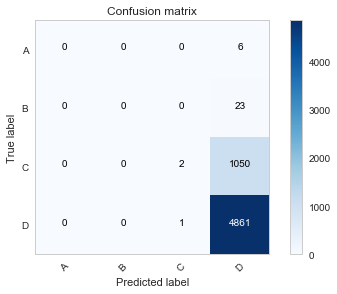

In [18]:
multinomial_logistic_reg('stats')
# f1_softmax = [multinomial_logistic_reg(course) for course in courses]

In [19]:
from sklearn import svm
def support_vector_classification(course=None, training=None, all_d=False):
    if all_d is False:
        training = pre_process(gen_training_data(course))
    discretize(training)
    Y = np.array(categorize(training['new_labels']))
    X = training.drop(['percent_grade','id', 'new_labels'], axis=1).values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=13)
    S = svm.SVC(kernel='rbf', C=5)
    S.fit(X_train, Y_train)
    tr_score = S.score(X_train, Y_train)
    ts_score = S.score(X_test, Y_test)
    Y_pred = S.predict(X_test)
    
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.figure()
    confusion = confusion_matrix(Y_test, Y_pred)
    plot_confusion_matrix(confusion, ["A", "B", "C", "D"])
    plt.savefig('cnf_svm.png')
    
    return f1_score(Y_test, Y_pred, average='weighted')

Confusion matrix, without normalization
[[   0    0    0    6]
 [   0    1    0   22]
 [   0    0   11 1041]
 [   0    0    6 4856]]


0.74054088836911602

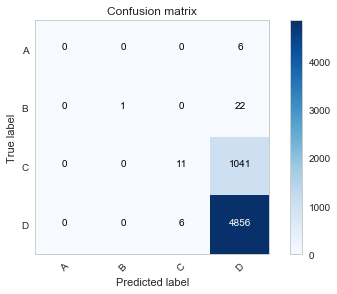

In [20]:
support_vector_classification('stats')
# f1_svm = [support_vector_classification(course) for course in courses]

In [257]:
def plot_f1():
    sns.set_style('whitegrid')
    '''
    Plotting code courtesy of 
    https://pythonspot.com/en/matplotlib-bar-chart/
    '''
    n_groups = 4
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(
        index, f1_softmax, bar_width, alpha=opacity,
        color='red', label='Softmax'
    )
    rects2 = plt.bar(
        index + bar_width, f1_svm, bar_width, 
        alpha=opacity,color='black',label='SVM'
    )

    plt.xlabel('Course')
    plt.ylabel('F-1 Score')
    plt.title('Performance on the 4 MOOCS')
    plt.xticks(index + bar_width, courses)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('cls.png')
    plt.show()

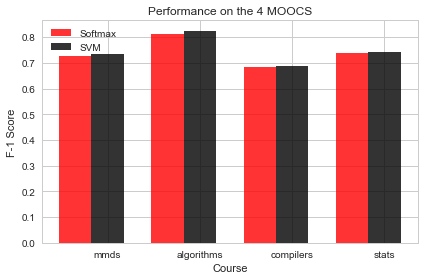

In [258]:
plot_f1()